First it'd be best to setup the environment. I've copied the raw courses from: 
https://gist.github.com/pat-coady/26fafa10b4d14234bfde0bb58277786d

Because this would take a while and be pretty tedious to do myself.

But we'd still need to convert this to some other format. 

I think the best thing to do first would be to setup the environment, then from there work on the reinforcement learning part of it.

Now that the environment is setup, we need to setup the target and behaviour policies.

The target will just be a greedy deterministic policy.

The behaviour policy will be epsilon greedy.

In [4]:
# Racetracks

# Left Race Track from Figure 5.5
big_course = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

# Tiny course for debug

tiny_course = ['WWWWWW',
               'Woooo+',
               'Woooo+',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'WooWWW',
               'W--WWW',]

In [3]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:

class RaceTrack:
    def __init__(self, course: list[str]):
        self.course = self._load_course(course)
        self.car_location = self._start()
        self.velocity = (0, 0)
        self.actions = [(y, x) for y in range(-1, 2) for x in range(-1, 2)]
        self.action_idxs = np.arange(9)

    def _pick_action(self, state: tuple[int, int, int, int], policy: np.array) -> int:
        if policy[*state].shape == ():
            return policy[*state]
        else:
            p_distribution = policy[*state]
            # Action array should be of size 9
            # Need to sample from it
            action_idx = np.random.choice(self.action_idxs, 1, p=p_distribution)[0]
        return action_idx

    def _load_course(self, string_course: list[str]) -> np.array:
        course = np.zeros((len(string_course), len(string_course[0])), dtype=np.int16)
        course_dict = {"W": -1, "o": 0, "-": 1, "+": 2}

        for i in range(len(course)):
            for j in range(len(course[i])):
                course[i, j] = course_dict[string_course[i][j]]

        return course
    
    def _start(self) -> tuple[int, int]:
        rows, cols = np.where(self.course == 1)
        coords = list(zip(rows, cols))
        start = random.randint(0, len(coords)-1)

        return coords[start]
    
    def _restart(self): # If we hit the car boundary
        self.car_location = self._start()
        self.velocity = (0, 0)
    
    def _apply_velocity(self, action: tuple[int, int]):
        y_vel = min(max(self.velocity[0] + action[0], 0), 5) # Bound to between 0-5
        x_vel = min(max(self.velocity[1] + action[1], 0), 5)
        self.velocity = (y_vel, x_vel)

    def _apply_movement(self) -> str:
        result = self._check_bounds()

        if result == "invalid":
            self._restart()
            return "restarted"
        elif result == "complete":
            return "done"
        else:
            return "continuing"
    
    def _check_bounds(self) -> str:
        y_vel, x_vel = self.velocity
        y, x = self.car_location

        max_x = len(self.course[0])
        all_positions = [(y, x)]
        max_vel = max(x_vel, y_vel)
        y_vel_count, x_vel_count = y_vel, x_vel
        y_temp, x_temp = y, x

        for _ in range(max_vel):
            if y_vel_count > 0 and x_vel_count > 0:
                y_temp -= 1
                x_temp += 1
                if y_temp < 0 or x_temp >= max_x:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
                x_vel_count -= 1
            elif y_vel_count > 0:
                y_temp -= 1
                if y_temp < 0:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                y_vel_count -= 1
            else:
                x_temp += 1
                if x_temp >= max_x:
                    return "invalid"
                all_positions.append((y_temp, x_temp))
                x_vel_count -= 1

        all_position_values = []

        for i, j in all_positions:
            all_position_values.append(self.get_course()[i, j])

        if -1 in all_position_values:
            return "invalid"
        elif 2 in all_position_values:
            return "complete"
        else:
            self.car_location = all_positions[-1]
            return "valid"

    def get_course(self) -> np.array:
        return self.course

    def generate_random_episode(self): # For testing (outdated)
        self.car_location = self._start()
        done = False

        while not done:
            action_idx = random.randint(0, len(self.actions)-1)
            action = self.actions[action_idx]
            self._apply_velocity(action)
            result = self._apply_movement()
            self.state_action_trajectory.append((self.car_location, action_idx))
            self.running_reward -= 1

            if result == "done":
                done = True

    def generate_episode(self, policy):
        self._restart()
        done = False
        trajectory = []

        while not done:
            y, x = self.car_location
            dy, dx = self.velocity
            state = (y, x, dy, dx)

            action_idx = self._pick_action(state, policy) # Take action
            trajectory.append((*state, action_idx))

            action = self.actions[action_idx]
            self._apply_velocity(action)

            result = self._apply_movement()
            if result == "done":
                done = True

        return trajectory

def mark_possible(possible_actions: np.array) -> np.array:
    "Marks impossible actions as 0"
    actions = np.array([(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2)])
    y_len, x_len, dy_len, dx_len, a_len = len(possible_actions), len(possible_actions[0]), 6, 6, len(actions)
    for y in range(y_len):
        for x in range(x_len):
            for dy in range(dy_len):
                for dx in range(dx_len):
                    for a in range(a_len):
                        dy_next, dx_next = actions[a]

                        dy = min(max(dy + dy_next, 0), 5) # Bound to between 0-5
                        dx = min(max(dx + dx_next, 0), 5)

                        if dy == dx == 0:
                            possible_actions[y, x, dy, dx, a] = 0

    return possible_actions

def init_equipropable_policy(policy: np.array, possible_actions: np.array) -> np.array:
    """Defines the equipropable policy where all possible actions have equal value
    Keyword being possible, as many actions aren't possible due to it causing velocity to be (0, 0)"""
    y_len, x_len, dy_len, dx_len, action_len = len(possible_actions), len(possible_actions[0]), 6, 6, 9
    for y in range(y_len):
        for x in range(x_len):
            for dy in range(dy_len):
                for dx in range(dx_len):
                    state = (y, x, dy, dx)
                    possible_actions_sum = np.sum(possible_actions[*state])
                    action_probabilty = 1/possible_actions_sum

                    possible_actions_mask = possible_actions[*state] == 1
                    policy[*state][possible_actions_mask] = action_probabilty 


    return policy
                    


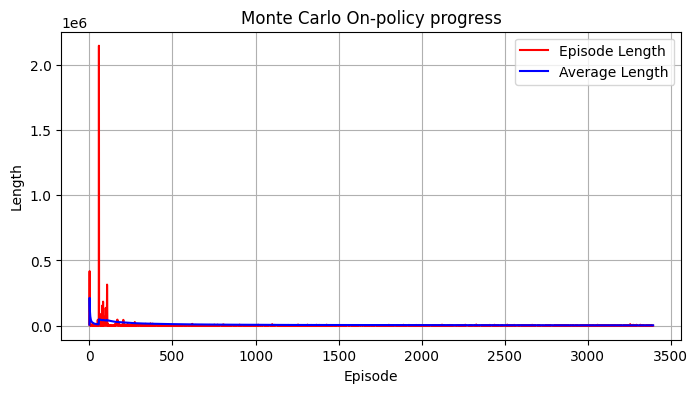

In [6]:
import numpy as np
random.seed(1)
np.random.seed(1)

course = big_course
actions = np.array([(dy, dx) for dy in range(-1, 2) for dx in range(-1, 2)])

# Define constants
MAX_VELOCITY = 5
GAMMA = 1 # Discount rate
EPSILON = 0.05 # Exploration factor for on-policy
THETA = 1e-3 # Breaking factor

# Setup behaviour policy
# Actions here could be represented as an array of size (9) or (3, 3)
# If it were 9, then the actions are grouped to be (-1, -1), (-1, 0), ..., (1, 1) etc.
# If it were (3, 3), then there's 3 possible actions for each axis, but I think this would be more annoying to implement

behaviour_policy = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) # Begin as equiprobable policy, will be stochastic
behaviour_q_values = np.zeros(behaviour_policy.shape)
behaviour_policy_counts = np.zeros(behaviour_policy.shape)

possible_actions = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) + 1 # Initially all actions are possible
possible_actions = mark_possible(possible_actions) # Mark impossible actions (impossilbe as per the problem description)

behaviour_policy = init_equipropable_policy(behaviour_policy, possible_actions) # Initialise all possilbe actions with equal possibility

race_track = RaceTrack(course)

plt.ion()
def on_policy_monte_carlo_control(race_track: RaceTrack, policy: np.array, q_values: np.array, counts: np.array, 
                                  gamma: float, epsilon: float, possible_actions: np.array, theta, 
                                  max_iterations: int = 100_000) -> np.array:
    episode_length_history = []
    episode_average_history = []

    for _ in range(max_iterations):
        state_action_trajectory = race_track.generate_episode(policy)
        current_return = 0
        timestep = len(state_action_trajectory)
        old_policy = policy.copy()
        old_q = q_values.copy()

        for state_action in reversed(state_action_trajectory):
            current_return = gamma * current_return + -1 # Taking advantage of how the reward structure for the problem is
            # We don't need the explicit overall reward as it's just the negative of the length of the trajectory
            timestep -= 1
            
            """
            If we want to use first-visit, we'd add this line:
            if state_action not in state_action_trajectory[:timestep]:
            
            However this makes it MUCH slower, increasing it from O(n) to O(n^2) as we need to check the whole trajectory for each timestep.
            So every-visit is MUCH faster in practice as it's O(n)

            """
            counts[*state_action] += 1
            q_values[*state_action] += (current_return-q_values[*state_action])/counts[*state_action]
            
            # Get Argmax (vectorised)
            possible_mask = possible_actions[*state_action[:-1]] == 1 
            best_a_idx = np.argmax(np.where(possible_mask, q_values[*state_action[:-1]], -np.inf))
            
            possible_actions_sum = np.sum(possible_actions[*state_action[:-1]])
            random_probability = epsilon/possible_actions_sum

            # Assign probabilities (vectorised)
            policy[*state_action[:-1]][possible_mask] = random_probability
            policy[*state_action[:-1], best_a_idx] += (1-epsilon)

        if np.all(old_policy == policy) and np.allclose(q_values, old_q, theta): # Breaking condition
            return policy

        episode_length_history.append(len(state_action_trajectory))
        episode_average_history.append(sum(episode_length_history)/len(episode_length_history))

        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(episode_length_history, label="Episode Length", color="red")
        plt.plot(episode_average_history, label="Average Length", color="blue")

        plt.xlabel("Episode")
        plt.ylabel("Length")
        plt.title("Monte Carlo On-policy progress")
        plt.legend()
        plt.grid(True)
        plt.show()

behaviour_policy = on_policy_monte_carlo_control(race_track, behaviour_policy, behaviour_q_values, behaviour_policy_counts, GAMMA, EPSILON, possible_actions, THETA)



In [13]:
from tqdm import tqdm

# Off policy

target_q_values = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1, len(actions))) # len(x), len(y), 6 speeds up and down (0-6), 9 possible actions. If it were state values, we'd just need v = x, y, 5, 5
target_policy = np.zeros((len(course), len(course[0]), MAX_VELOCITY+1, MAX_VELOCITY+1), dtype=np.int32) + 4 # Need an array for each state, default value set to (0, 0), no need for 9 actions per state as it's deterministic, so just set it as the index
c_values = np.zeros(target_q_values.shape) # Need the same shape for our running importance sampling sum

race_track = RaceTrack(course)

def off_policy_monte_carlo(race_track: RaceTrack, target_policy: np.array, target_q_values: np.array, behaviour_policy: np.array,
                            possible_actions: np.array, gamma: float, max_iterations: int = 50_000) -> np.array:
    c_values = np.zeros(target_q_values.shape)

    for i in tqdm(range(max_iterations)):
        traj = race_track.generate_episode(behaviour_policy)
        G = 0 # Return
        W = 1 # Running importance sampling ratio

        for state_action in reversed(traj):
            G = gamma * G + -1
            c_values[*state_action] += W 
            target_q_values[*state_action] += (W/c_values[*state_action]) * (G-target_q_values[*state_action])
            
            possible_actions_mask = possible_actions[*state_action[:-1]] == 1
            best_a_idx = np.argmax(np.where(possible_actions_mask, target_q_values[*state_action[:-1]], -np.inf))
            target_policy[*state_action[:-1]] = best_a_idx

            if target_policy[*state_action[:-1]] != state_action[-1]:
                break 
            else:
                W *= 1/behaviour_policy[state_action]

    return target_policy


target_policy = off_policy_monte_carlo(race_track, target_policy, target_q_values, behaviour_policy, possible_actions, GAMMA)
print("Reward: ", len(race_track.generate_episode(target_policy)))



100%|██████████| 50000/50000 [13:37<00:00, 61.14it/s]  


KeyboardInterrupt: 

In [93]:

print(behaviour_policy[0, 0, 0, 0].shape)
print(target_policy[0, 0, 0, 0].shape)

print(target_policy[0, 0, 0, 0].shape == ())

(9,)
()
True
